<a href="https://colab.research.google.com/github/fressbish/Koptev-Dmitry/blob/main/KoptevDA_hw1_gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Коптев Д.А., GNN, Задание 1

## Задача 1. Hand-crafted graph features

- Найти или сгенерировать набор данных для бинарной классификации графов.
- Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test
-- Опишите графы с помощью вектора из количества кратчайших путей различной длины
-- Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
-- Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
-- K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
-- K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными
- Используя реализованное ядро обучите модель SVC, подберите гиперпараметры, вычислите различные метрики качества
- (+5 баллов) Также реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [1]:
import numpy as np
from collections import defaultdict

import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV
from ogb.graphproppred import GraphPropPredDataset

### **Загружаем датасет**

In [2]:
dataset = GraphPropPredDataset(name='ogbg-molhiv')
labels = dataset.labels.flatten()

/usr/local/lib/python3.10/dist-packages/ogb/graphproppred/dataset.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_dict = torch.load(pre_processed_file_path, 'rb'

In [3]:
# кол-во нулей и единиц
np.count_nonzero(labels==0), np.count_nonzero(labels==1)

(39684, 1443)

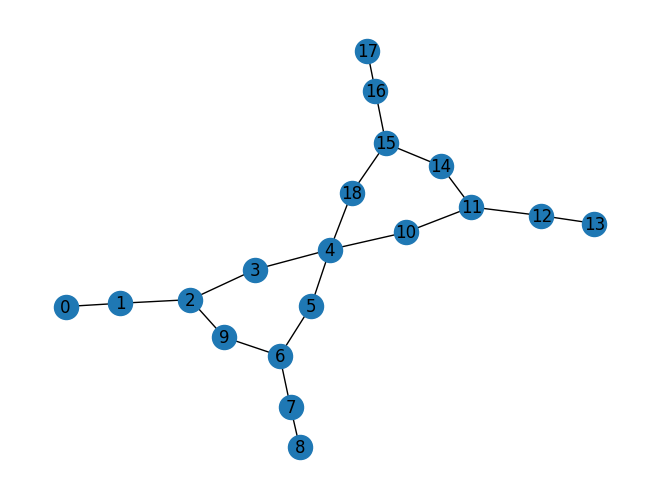

In [4]:
# Граф с меткой 0
negative_graph_data = dataset[np.where(labels == 0)[0][0]][0]
# фичи для узлов и ребер
node_features = negative_graph_data['node_feat']
edge_features = negative_graph_data['edge_feat']
edge_list = list(zip(negative_graph_data['edge_index'][0], negative_graph_data['edge_index'][1]))

graph = nx.Graph()
graph.add_edges_from(edge_list)
nx.draw(graph, with_labels=True)

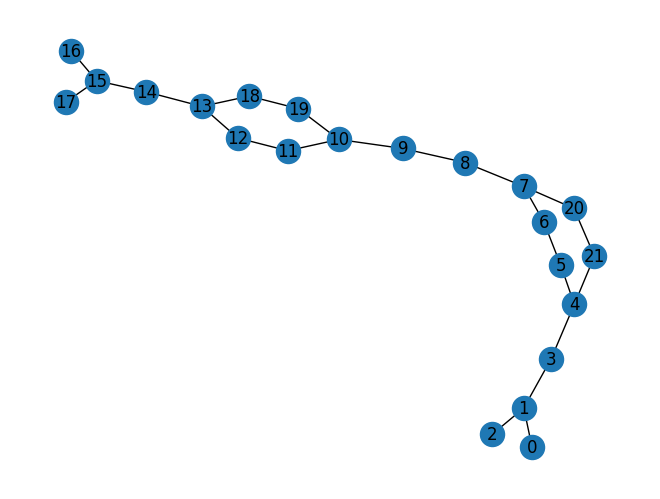

In [5]:
# Теперь посмотрим на грф в меткой 1
negative_graph_data = dataset[np.where(labels == 1)[0][0]][0]
# фичи для узлов и ребер
node_features = negative_graph_data['node_feat']
edge_features = negative_graph_data['edge_feat']
edge_list = list(zip(negative_graph_data['edge_index'][0], negative_graph_data['edge_index'][1]))

graph = nx.Graph()
graph.add_edges_from(edge_list)
nx.draw(graph, with_labels=True)

### **Функция shortest_path_kernel**
Реализовать функцию shortest_path_kernel(train_graphs, test_graphs), которая принимает тренировочный и тестовые наборы, а возвращает пару K_train, K_test

- Опишите графы с помощью вектора из количества кратчайших путей различной длины
- Для вычисления длин кратчайших путей можно использовать nx.shortest_path_length(G)
- Ядровая функция для сравнения двух графов - скалярное произведение их двух векторов
- K_train - матрица из ядровых функций для сравнения тренировочных графов между собой
- K_test - матрица из ядровых функций для сравнения тестовых графов с тренировочными

In [6]:
def shortest_path_kernel(train_graphs, test_graphs):

    train_vectors = []
    for graph in train_graphs:
        lengths_dict = dict(nx.shortest_path_length(graph))
        max_path_length = max(max(lengths.values()) for lengths in lengths_dict.values() if lengths)
        vector_representation = np.zeros(max_path_length + 1)

        for lengths in lengths_dict.values():
            for length in lengths.values():
                vector_representation[length] += 1
        train_vectors.append(vector_representation)

    test_vectors = []
    for graph in test_graphs:
        lengths_dict = dict(nx.shortest_path_length(graph))
        max_path_length = max(max(lengths.values()) for lengths in lengths_dict.values() if lengths)
        vector_representation = np.zeros(max_path_length + 1)

        for lengths in lengths_dict.values():
            for length in lengths.values():
                vector_representation[length] += 1
        test_vectors.append(vector_representation)

    # Приведение векторов к одинаковой длине
    combined_length = max(max(len(v) for v in train_vectors), max(len(v) for v in test_vectors))
    train_vectors = [np.pad(v, (0, combined_length - len(v))) for v in train_vectors]
    test_vectors = [np.pad(v, (0, combined_length - len(v))) for v in test_vectors]

    # Расчет матриц K_train и K_test с помощью скалярного произведения
    K_train_matrix = np.dot(train_vectors, np.transpose(train_vectors))
    K_test_matrix = np.dot(test_vectors, np.transpose(train_vectors))

    return K_train_matrix, K_test_matrix


In [7]:
# Приведем edge_index к типу networkx объектов
graph_list = []
for data, _ in dataset:
    edge_list = list(zip(data['edge_index'][0], data['edge_index'][1]))
    graph = nx.Graph()
    graph.add_edges_from(edge_list)
    graph_list.append(graph)

In [8]:
indices = np.concatenate([np.where(labels == 0)[0][:1000], np.where(labels == 1)[0][:1000]])
graphs = [graph_list[i] for i in indices]
labels = labels[indices]

# Разделим данные с помощью train_test_split
train_graphs, test_graphs, train_labels, test_labels = train_test_split(graphs, labels, test_size=0.2, random_state=42)

# Применим shortest_path_kernel, чтобы получить пару K_train, K_test
K_train, K_test = shortest_path_kernel(train_graphs, test_graphs)
K_train.shape, K_test.shape

((1600, 1600), (400, 1600))

In [9]:
# gridsearch
params = {'C': [0.1, 1, 10]}
svc = SVC(kernel='precomputed')
grid_search = GridSearchCV(svc, params, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(K_train, train_labels)
best_model = grid_search.best_estimator_

# прогнозы
train_pred = best_model.predict(K_train)
test_pred = best_model.predict(K_test)

# метрики качества
train_accuracy = accuracy_score(train_labels, train_pred)
test_accuracy = accuracy_score(test_labels, test_pred)
test_f1 = f1_score(test_labels, test_pred)

train_accuracy, test_accuracy, test_f1

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..............................................C=0.1; total time=   4.9s
[CV] END ..............................................C=0.1; total time=   2.2s
[CV] END ..............................................C=0.1; total time=   2.6s
[CV] END ................................................C=1; total time=  18.7s
[CV] END ................................................C=1; total time=  18.6s
[CV] END ................................................C=1; total time=  12.9s
[CV] END ...............................................C=10; total time= 3.5min
[CV] END ...............................................C=10; total time= 2.5min
[CV] END ...............................................C=10; total time= 4.6min


(0.669375, 0.65, 0.6276595744680851)

In [10]:
print(classification_report(test_labels, test_pred))

              precision    recall  f1-score   support

           0       0.63      0.71      0.67       199
           1       0.67      0.59      0.63       201

    accuracy                           0.65       400
   macro avg       0.65      0.65      0.65       400
weighted avg       0.65      0.65      0.65       400



## Weisfeiler-Lehman Kernel
Реализовать Weisfeiler-Lehman Kernel и обучить классификатор с ним, сравнить результаты.

In [11]:
def wlk(train_graphs, test_graphs, h=2):
    """Вычисляет ядровые матрицы для обучающих и тестовых графов с использованием алгоритма Уайзфейлера-Лемана."""

    # Инициализация меток (все узлы начинают с одинаковой метки)
    train_labels = [{node: 1 for node in graph.nodes()} for graph in train_graphs]
    test_labels = [{node: 1 for node in graph.nodes()} for graph in test_graphs]

    # Словари для хранения частот меток
    train_label_freq = [defaultdict(int) for _ in range(len(train_graphs))]
    test_label_freq = [defaultdict(int) for _ in range(len(test_graphs))]

    for _ in range(h):
        # Обновление меток для тренировочных графов
        for idx, graph in enumerate(train_graphs):
            new_labels = {}
            for node in graph.nodes():
                neighbor_labels = sorted(train_labels[idx][neighbor] for neighbor in graph.neighbors(node))
                new_labels[node] = hash((train_labels[idx][node], tuple(neighbor_labels)))
            train_labels[idx] = new_labels

            for label in new_labels.values():
                train_label_freq[idx][label] += 1

        # Обновление меток для тестовых графов
        for idx, graph in enumerate(test_graphs):
            new_labels = {}
            for node in graph.nodes():
                neighbor_labels = sorted(test_labels[idx][neighbor] for neighbor in graph.neighbors(node))
                new_labels[node] = hash((test_labels[idx][node], tuple(neighbor_labels)))
            test_labels[idx] = new_labels

            for label in new_labels.values():
                test_label_freq[idx][label] += 1

    # Вычисление K_train и K_test
    K_train = np.zeros((len(train_graphs), len(train_graphs)))
    K_test = np.zeros((len(test_graphs), len(train_graphs)))

    for i in range(len(train_graphs)):
        for j in range(i, len(train_graphs)):
            common_labels = set(train_label_freq[i].keys()) & set(train_label_freq[j].keys())
            K_train[i, j] = K_train[j, i] = sum(min(train_label_freq[i][label], train_label_freq[j][label]) for label in common_labels)

    for i in range(len(test_graphs)):
        for j in range(len(train_graphs)):
            common_labels = set(test_label_freq[i].keys()) & set(train_label_freq[j].keys())
            K_test[i, j] = sum(min(test_label_freq[i][label], train_label_freq[j][label]) for label in common_labels)

    return K_train, K_test

In [12]:
K_train_wlk, K_test_wlk = wlk(train_graphs, test_graphs)
K_train_wlk.shape, K_test_wlk.shape

((1600, 1600), (400, 1600))

In [13]:
# Обучим модель
param_grid = {'C': [0.1, 1, 10]}
svc_wlk = SVC(kernel='precomputed')
grid_search_wlk = GridSearchCV(svc_wlk, param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search_wlk.fit(K_train_wlk, train_labels)
best_model_wlk = grid_search_wlk.best_estimator_

# Прогнозы
test_pred_wlk = best_model_wlk.predict(K_test_wlk)
test_accuracy_wlk = accuracy_score(test_labels, test_pred_wlk)
test_f1_wlk = f1_score(test_labels, test_pred_wlk)

test_accuracy_wlk, test_f1_wlk

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ..............................................C=0.1; total time=   0.0s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ................................................C=1; total time=   0.1s
[CV] END ...............................................C=10; total time=   1.1s
[CV] END ...............................................C=10; total time=   1.3s
[CV] END ...............................................C=10; total time=   1.4s


(0.7725, 0.7753086419753087)

In [14]:
print(classification_report(test_labels, test_pred_wlk))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       199
           1       0.77      0.78      0.78       201

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400



У Weisfeiler-Lehman Kernel presicion, recall и f1-score выше +- на 0.1